## 서울시 따릉이 수요 예측

#### < 라이브러리 import >

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import seaborn as sns
sns.set()
import matplotlib
from IPython.display import set_matplotlib_formats

matplotlib.rc('font', family='NanumGothic')

matplotlib.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')
%matplotlib inline

#### < 데이터 load >

In [3]:
train = pd.read_csv("./data/tmp_data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

In [4]:
print(train.shape)
train.head(5)

(1459, 11)


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


count    1459.000000
mean      108.563400
std        82.631733
min         1.000000
25%        37.000000
50%        96.000000
75%       150.000000
max       431.000000
Name: count, dtype: float64

Text(0.5, 1.0, 'target distribution')

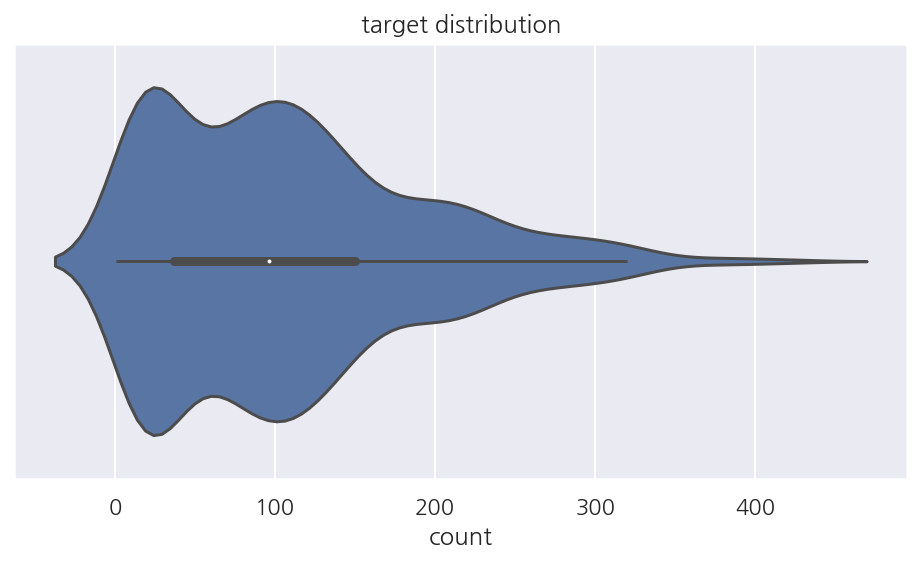

In [6]:
## target에 대한 통계량 , 분포 확인
display(train['count'].describe())

plt.figure(figsize=(8,4))
sns.violinplot(train['count'])
plt.title("target distribution")

#### < 베이스라인 모델링 >

* 베이스라인 모델
    * simple Linear Regression
    * 베이스라인 모델을 기준으로 점차 지표 개선여부 확인.

In [7]:
# 평가지표 RMSE 계산 함수
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

In [8]:
features = train.dropna().loc[:,:"hour_bef_pm2.5"]
target = train.dropna()['count']

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3,stratify=features['hour'])

# baseline model
base_model = LinearRegression()

base_model.fit(X_train,y_train)

base_cv_scores = cross_val_score(base_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
base_rmse_cv_scores = np.sqrt(-1*base_cv_scores)
base_rmse = np.mean(base_rmse_cv_scores)

base_pred = base_model.predict(X_test)
base_test_rmse = rmse(y_test,base_pred)

print("base model 5 CV rmse : ",base_rmse)
print("base model test rmse : ",base_test_rmse)

base model 5 CV rmse :  53.17593150699336
base model test rmse :  54.746603474131796


* base model의 회귀계수 시각화

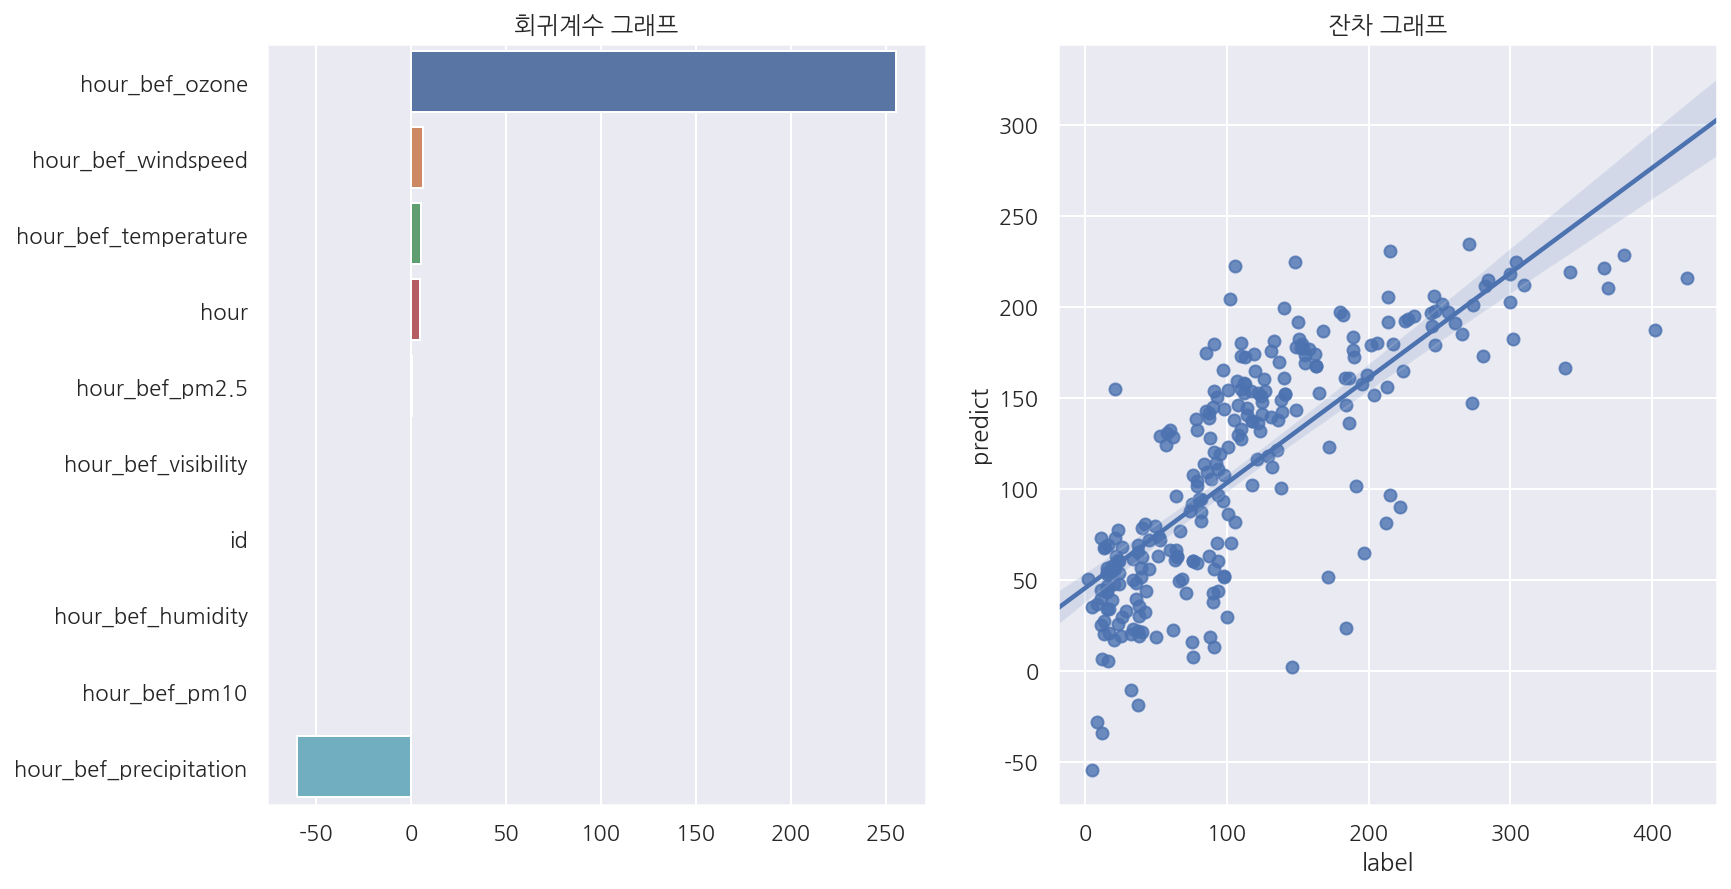

In [9]:
## 회귀계수 그래프
coef = pd.Series(base_model.coef_, index=features.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(base_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

####  < simple Feature Engineering & modeling version 1 >
    * 단순 식별자인 id 컬럼 제거
    * 데이터 표준화 진행 (Standard Scaling)
    * hour 피처의 원-핫 인코딩

Text(0.5, 1.0, '시간대별 대여횟수 평균')

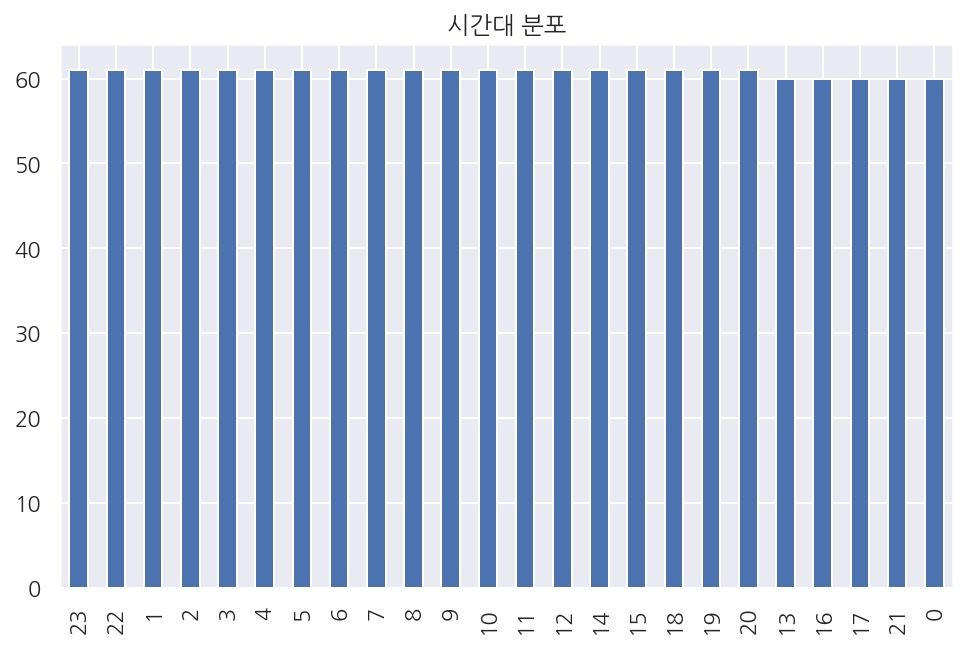

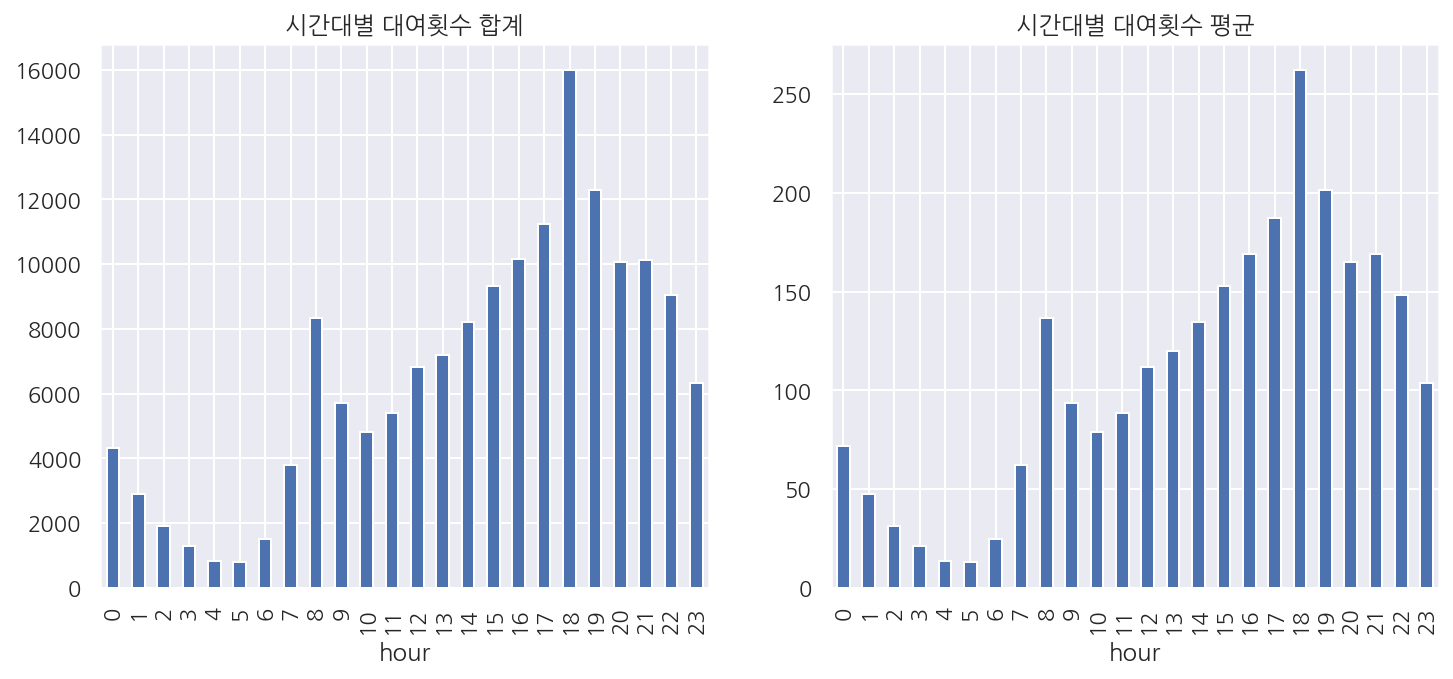

In [10]:
# 시간대 분포
plt.figure(figsize=(8,5))
train['hour'].value_counts().plot(kind='bar')
plt.title("시간대 분포")

# 시간대별 대여횟수 분포 # 합계
plt.figure(figsize=(12,5))
plt.subplot(121)
train.groupby('hour')['count'].sum().plot(kind='bar')
plt.title("시간대별 대여횟수 합계")

# 시간대별 대여횟수 분포 # 평균
plt.subplot(122)
train.groupby('hour')['count'].mean().plot(kind='bar')
plt.title("시간대별 대여횟수 평균")

* 시간대의 경우 데이터 내에 0~24시가 균등하게 분포하고 있음
* 시간대별 대여횟수의 경우 시간대별로 확연한 차이가 보임.
    * 0~6시까지는 가장 낮은 대여횟수를 보이며 감소추세임.
    * 7,8시부터 다시 대여횟수가 증가함. 또, 17,18,19시에 가장 높은 대여횟수를 가지는것으로 보아 출퇴근시에 따릉이를 이용하는 사람들이 많은것으로 보임.
* 시간대별로 확연한 차이가 보이므로 원-핫 인코딩을 통해 개별 피처로 활용할것.
    * 선형 모델의 경우 one-hot 피처로
    *  Tree 기반 회귀의 경우 one-hot 피처로 변경하지 않을것.[(참고)](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

* regplot을 통한 타겟(count)과 변수관 관계 파악

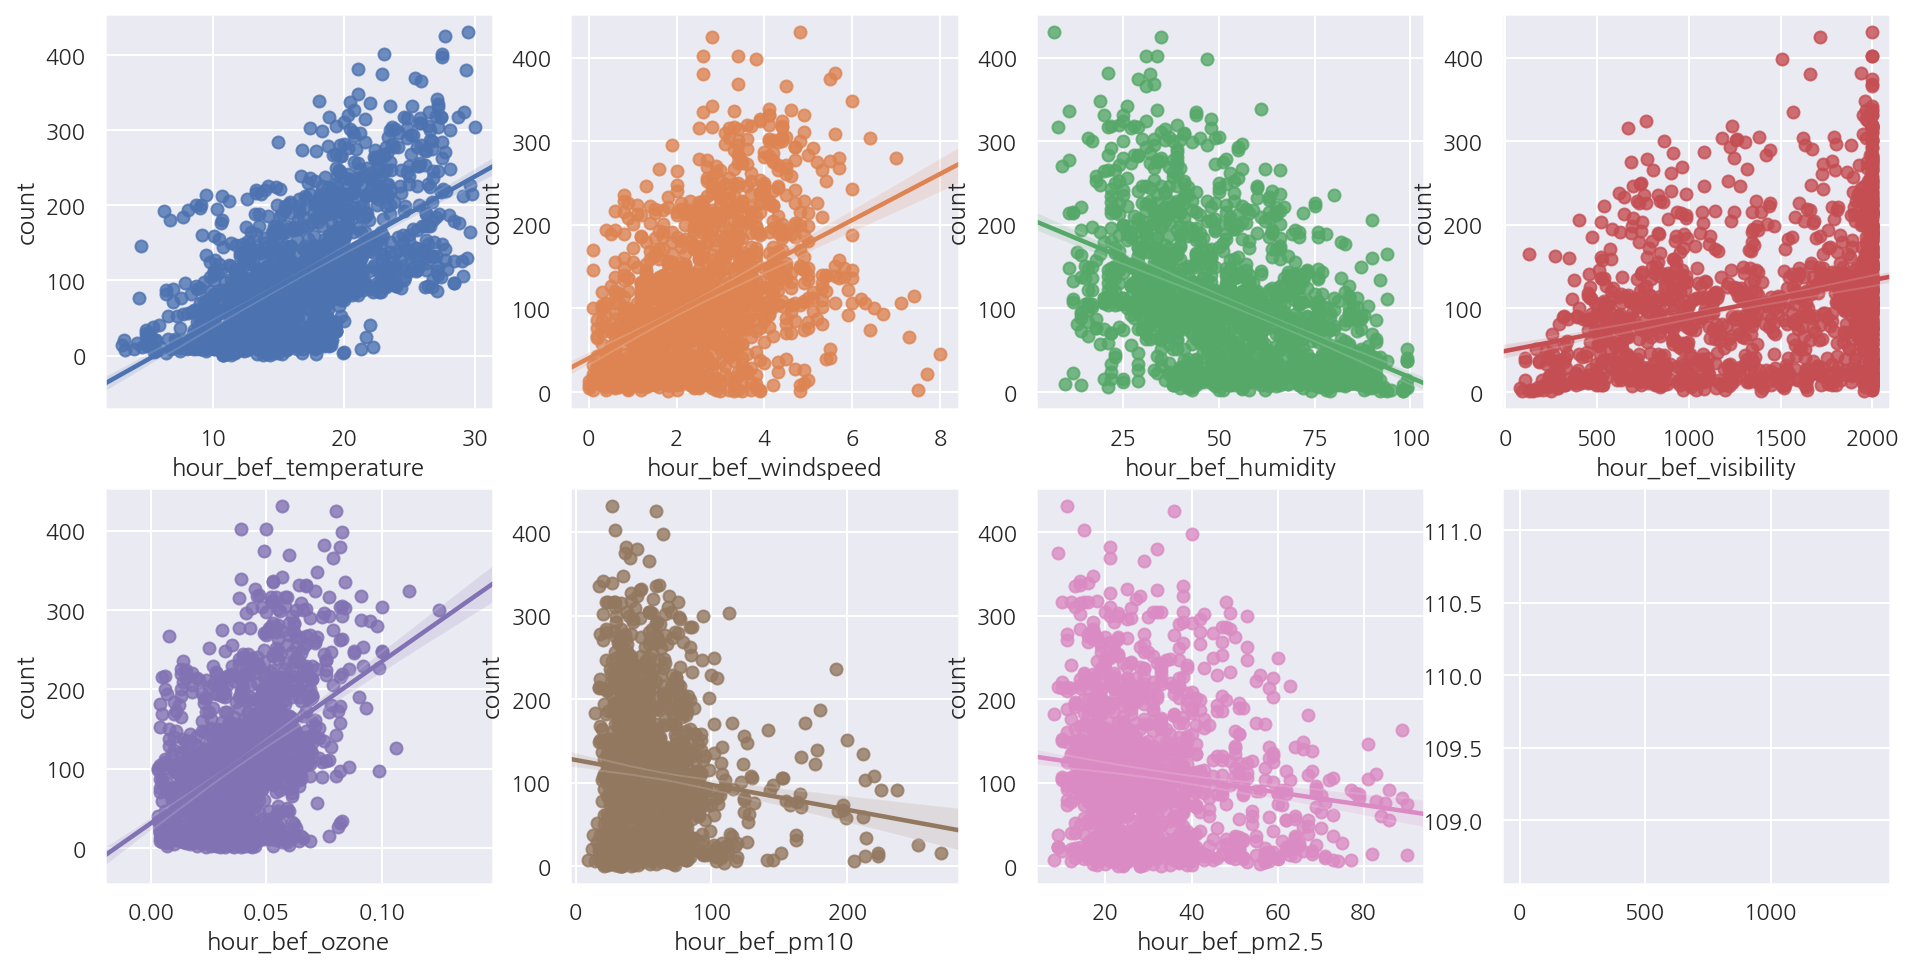

In [11]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity',
               'hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']

for i,feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='count',data=train, ax=axs[row][col])

* 전처리 진행 후 modeling
    * id컬럼 제거
    * standard scaling
    * hour, precipitation(강수여부) 원-핫 인코딩
    * 모델은 Simple Linear Regression

In [12]:
# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing_lr_v1(data):
    
    data = data.copy()
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.dropna().loc[:,:"hour_bef_pm2.5"] # 결측값 제거 # 피처 선택
    target = data.dropna()['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v1(train)   


# model _ 1
model_1 = LinearRegression()

model_1.fit(X_train,y_train)

model_1_cv_scores = cross_val_score(model_1, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_1_rmse_cv_scores = np.sqrt(-1*model_1_cv_scores)
model_1_rmse = np.mean(model_1_rmse_cv_scores)

model_1_pred = model_1.predict(X_test)
model_1_test_rmse = rmse(y_test,model_1_pred)

print("model_1 5 CV rmse : ",model_1_rmse)
print("model_1 test rmse : ",model_1_test_rmse)

model_1 5 CV rmse :  42.07340535856227
model_1 test rmse :  46.3587094305012


In [13]:
## 전처리 적용 후의 data
res_df.head(5)

,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hour_0,hour_2,hour_3,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_bef_precipitation_0.0,hour_bef_precipitation_1.0
0,-0.108967,-0.716090,1.848215,-1.451638,-0.622533,0.593375,0.177633,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.622564,-0.788435,-0.185569,-0.862425,0.149769,0.497250,0.652684,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.570987,-1.294846,1.352170,-0.054858,-0.313612,-0.816461,-0.772469,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-1.687533,0.152043,0.112058,-0.810436,0.046796,0.561333,2.281431,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,2.432140,1.671277,-2.219352,1.016123,0.922071,-0.976669,-1.315385,0,0,0,...,0,0,1,0,0,0,0,0,1,0


* 간단한 데이터 전처리만으로도 base model에 비해 예측성능이 크게 향상되었음.

* 각 피처의 회귀계수 값을 시각화해 본다.

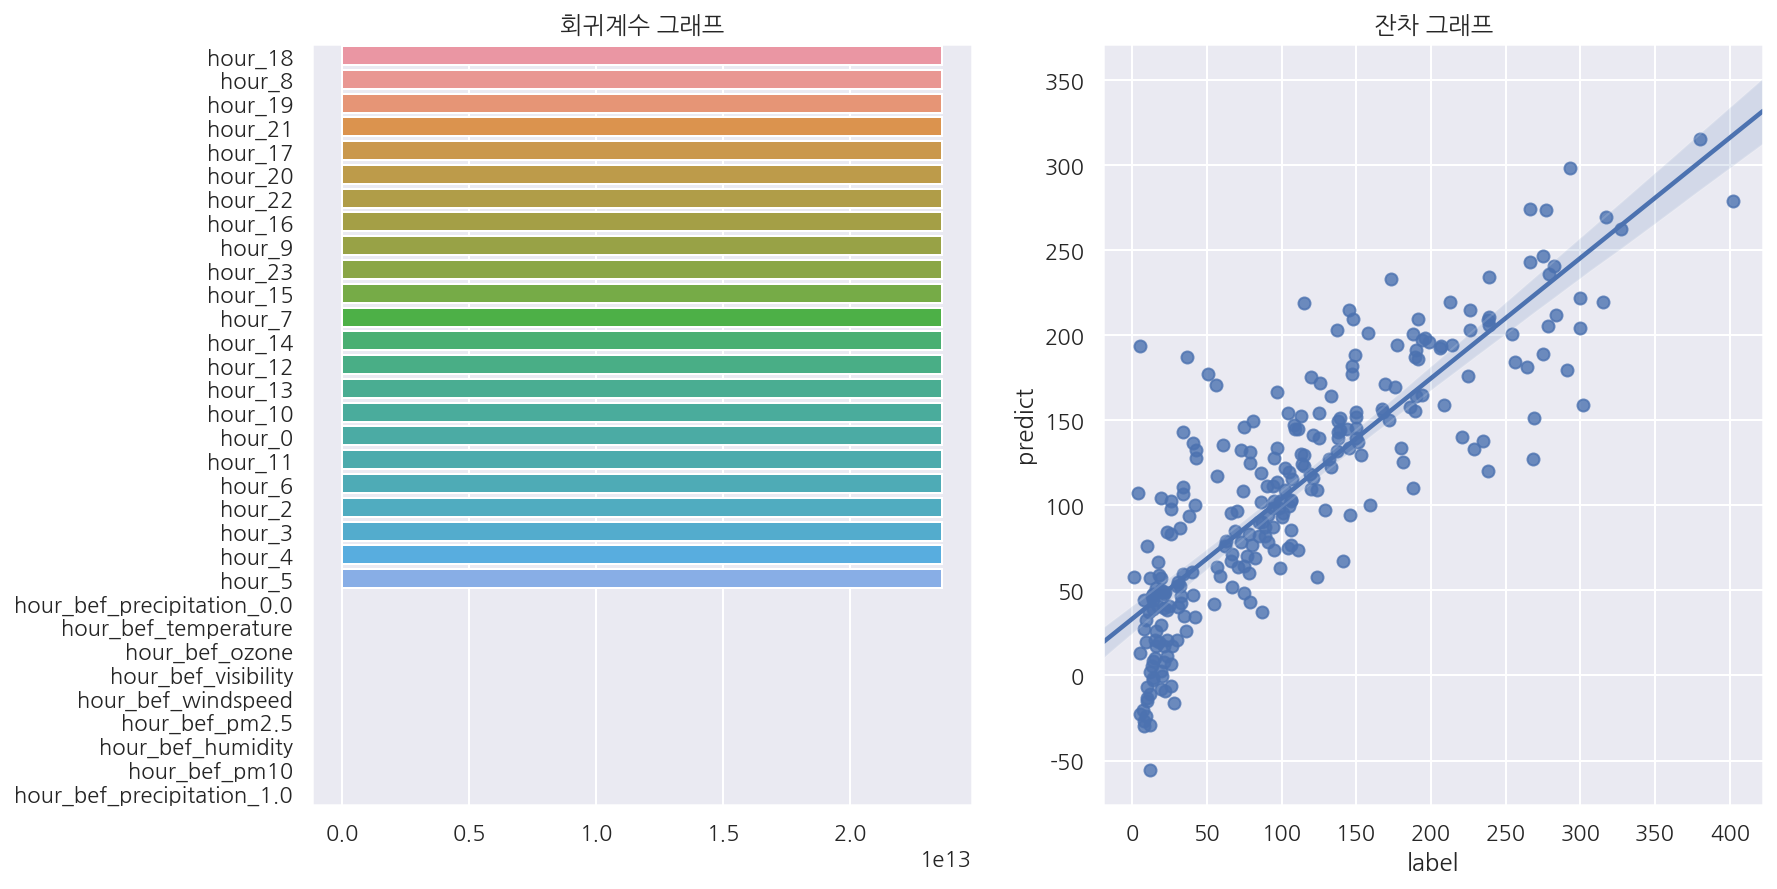

In [14]:
## 회귀계수 그래프
coef = pd.Series(model_1.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_1_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* hour 피처들의 회귀 계수가 높다. (hour 외에는 영향을 미치는 피처가 없다..)
* hour들의 회귀계수가 전부 동일하게 계산되었다. 아마 무언가 잘못되었을 가능성이 큰.... 우선 진행해보고 차후에 검증해보자..

####  < simple Feature Engineering & modeling version 1 >
    * model_1의 데이터 전처리 과정에 결측값에 대한 부분이 빠져있다.
    * 결측값에 대한 전처리를 진행한 후 model_2를 만들어본다.

In [15]:
## 결측치 파악
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

* 모든 피처가 각 시간대의 정보를 담고 있다.
* 따라서 해당 피처의 시간대별 평균치로 결측값을 대체한다.
    * 단, 우천 여부를 나타내는 hour_bef_precipitation 컬럼의 경우 삭제한다.
    * ozone, pm10, pm2.5의 경우 1시에 측정된 값이 모두 결측치이다. 앞뒤 시간인 0,2시의 평균치로 대체한다.

In [16]:
def del_nan(df):
    df = df.copy()
    # 1차
    # 각 시간대별 평균값으로 결측치 대체
    df['hour_bef_temperature'].fillna(df.groupby('hour')['hour_bef_temperature'].transform('mean'),inplace=True)
    df['hour_bef_windspeed'].fillna(df.groupby('hour')['hour_bef_windspeed'].transform('mean'),inplace=True)
    df['hour_bef_humidity'].fillna(df.groupby('hour')['hour_bef_humidity'].transform('mean'),inplace=True)
    df['hour_bef_visibility'].fillna(df.groupby('hour')['hour_bef_visibility'].transform('mean'),inplace=True)
    df['hour_bef_ozone'].fillna(df.groupby('hour')['hour_bef_ozone'].transform('mean'),inplace=True)
    df['hour_bef_pm10'].fillna(df.groupby('hour')['hour_bef_pm10'].transform('mean'),inplace=True)
    df['hour_bef_pm2.5'].fillna(df.groupby('hour')['hour_bef_pm2.5'].transform('mean'),inplace=True)
    
    # 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치와 hour_bef_precipitation 결측치만 남음.
   # ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
    for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        hour_0 = df[df['hour'] == 0][col].mean()
        hour_2 = df[df['hour'] == 2][col].mean()
        res = np.mean([hour_0,hour_2])
        df[col] = df[col].fillna(res)
        
    # hour_bef_precipitation 결측치 제거
#     df = df.dropna()
    df = df.fillna(0)
    
    return df

dropna_train = del_nan(train)

In [17]:
## 결측치 대체 후 
dropna_train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

* 결측치 제거 완료 후, model_2 진행

In [18]:
# 전처리 후 train/test 반환
## 단순 식별자인 id컬럼 제거
## 데이터 표준화 진행
def data_preprocessing_lr_v2(df):
    
    df = df.copy()
    
    # 결측값 제거 
    df = del_nan(df)
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = df.loc[:,:"hour_bef_pm2.5"] # 피처 선택
    target = df['count'] # target
    
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    
    res_df = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_df[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(res_df,target,test_size=0.2,random_state=3)
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,res_df

    
# get train/test    
X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v2(train)   


# model _ 2
model_2 = LinearRegression()

model_2.fit(X_train,y_train)

model_2_cv_scores = cross_val_score(model_2, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
model_2_rmse_cv_scores = np.sqrt(-1*model_2_cv_scores)
model_2_rmse = np.mean(model_2_rmse_cv_scores)

model_2_pred = model_2.predict(X_test)
model_2_test_rmse = rmse(y_test,model_2_pred)

print("model_2 5 CV rmse : ",model_2_rmse)
print("model_2 test rmse : ",model_2_test_rmse)

model_2 5 CV rmse :  42.99010885143
model_2 test rmse :  39.79521563727689


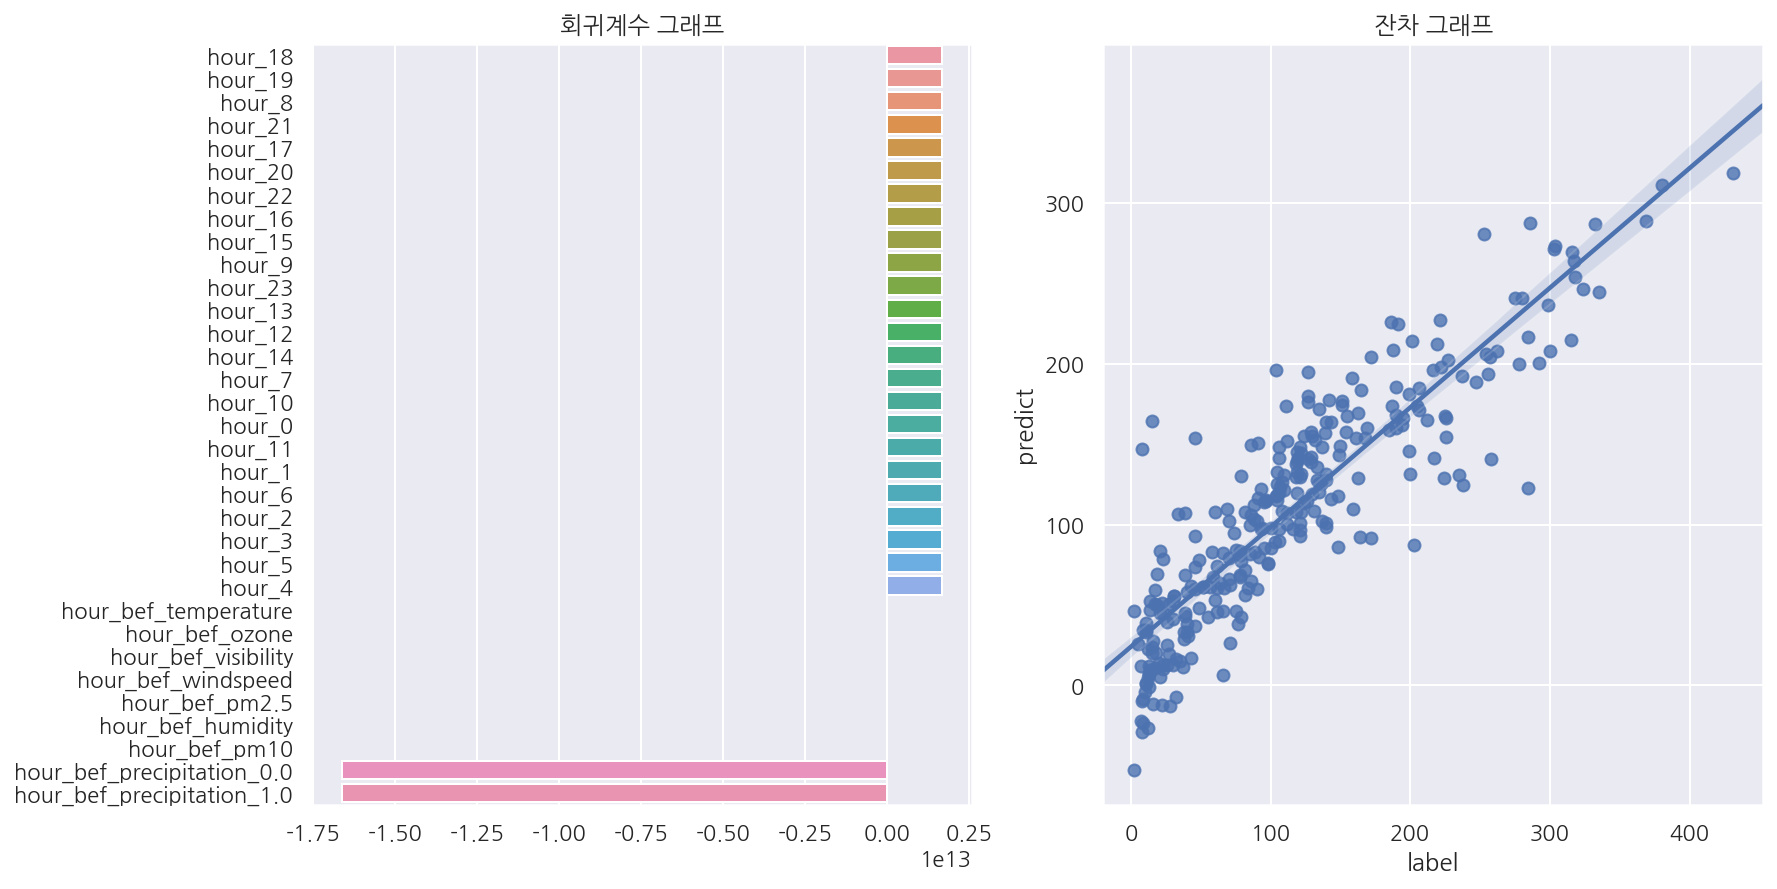

In [19]:
## 회귀계수 그래프
coef = pd.Series(model_2.coef_, index=res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.subplot(121)
plt.title("회귀계수 그래프")
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 잔차 그래프
residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(model_2_pred)],axis=1)
residual.columns = ['label','predict']
residual.index = y_test.index
residual['diff']  = np.abs(residual['label'] - residual['predict'])
plt.subplot(122)
plt.title("잔차 그래프")
sns.regplot(x = 'label', y = 'predict', data = residual)

* 회귀계수를 살펴보면 우천여부에 대한 피처가 높은 영향을 보이는것을 알 수 있다.
    * 강수 여부가 자전거 대여 횟수에 큰 영향을 끼치는것으로 보인다.

#### < Ridge, Lasso, Elastic Net >
    * Ridge, Lasso, ElasticNet을 통해 선형 모델링에 L1,L2의 규제를 적용해본다.

In [20]:
# Ridge / Lasso / Elastic Net
def find_best_params_model(data, model, params):
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing_lr_v2(data)
    
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_train, y_train)
    grid_model_rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 params:{2}'.format(model.__class__.__name__,
                                                             np.round(grid_model_rmse,4),grid_model.best_params_))
    
    grid_model_pred = grid_model.predict(X_test)
    grid_model_test_rmse = rmse(y_test,grid_model_pred)
    
    print('test rmse : ', grid_model_test_rmse)
    print('###################################')
    
    return grid_model # best parameter로 학습 된 모델 반환
    
    
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 10, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}   
elastic_params = {'alpha':[0.001,0.05, 0.1, 0.5, 1],
                 'l1_ratio':[0.1,0.5,1,5]}

model_ridge = find_best_params_model(train,ridge,ridge_params)
model_lasso = find_best_params_model(train,lasso,lasso_params)
model_elastic = find_best_params_model(train,elastic,elastic_params)

Ridge 5 CV 시 최적 평균 RMSE 값:43.1225, 최적 params:{'alpha': 1}
test rmse :  39.8511115956106
###################################
Lasso 5 CV 시 최적 평균 RMSE 값:43.1056, 최적 params:{'alpha': 0.05}
test rmse :  39.80067909289057
###################################
ElasticNet 5 CV 시 최적 평균 RMSE 값:43.1056, 최적 params:{'alpha': 0.05, 'l1_ratio': 1}
test rmse :  39.80067909289057
###################################


* RMSE 값이 크게 개선되지는 않았다.
* Ridge, Lasso, Elastic Net 모델별 회귀계수를 살펴본다

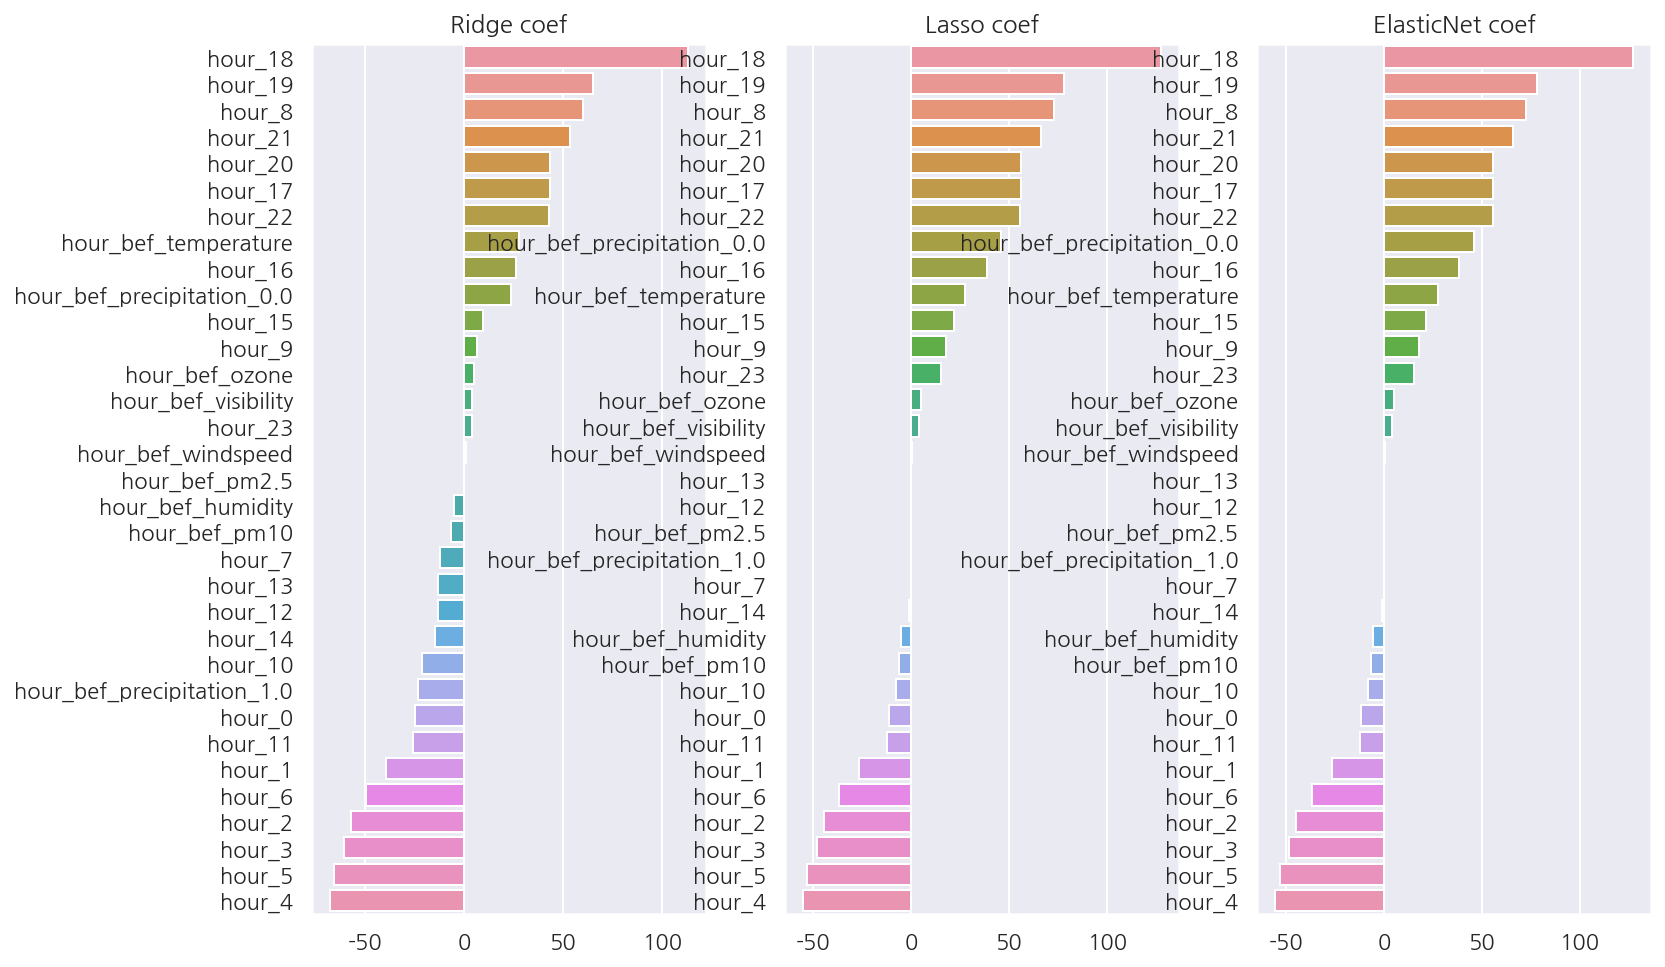

In [21]:
coef = pd.Series(model_ridge.best_estimator_.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.title('Ridge coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_lasso.best_estimator_.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,2)
plt.title('Lasso coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

coef = pd.Series(model_elastic.best_estimator_.coef_, index = res_df.columns)
coef_sort = coef.sort_values(ascending=False)
plt.subplot(1,3,3)
plt.title('ElasticNet coef')
sns.barplot(x=coef_sort.values, y=coef_sort.index)

#### < Tree based Regression >

In [ ]:
def data_preprocessing_nlr_v1(df): # for not Linear
    
    df = df.copy()
    
#     결측값 제거
    df = del_nan(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3,stratify=features['hour'])
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features


# RandomForestRegressor
def find_best_params(data, model, params, preprocessing_def): # train , model, params, 전처리 함수 버전
    
    data_preprocessing_nlr = preprocessing_def
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(data)
    
    grid_model = GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_train, y_train)
    grid_model_rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 parameter:{2}'.format(model.__class__.__name__,
                                                             np.round(grid_model_rmse,4),grid_model.best_params_))
    
    grid_model_pred = grid_model.predict(X_test)
    grid_model_test_rmse = rmse(y_test,grid_model_pred)
        
    print('test rmse : ', grid_model_test_rmse)
    print('###################################')
    
    
    df_diff = pd.DataFrame({'label':y_test, 'predict':grid_model_pred},index=X_test.index)
    df_diff['diff'] = np.abs(df_diff['label'] - df_diff['predict'])
    display(df_diff.head(10).sort_values(by='diff',ascending=False))
    
    return grid_model,grid_model_pred # best parameter로 학습 된 모델 반환
    
    
RandomForest = RandomForestRegressor(random_state=3)
xgboost = XGBRegressor(n_estimators=1000,silent=True)
lgbm = LGBMRegressor(n_estimators=1000,n_jobs=-1) 

RandomForest_params = {'n_estimators':[300,500],
                 'max_depth':[16,21,32,64]}

xgboost_params = {'learning_rate':[0.03,0.05,0.1],
                 'colsample_bytree':[0.1,0.5,0.8],
                 'subsample':[0.6,0.8]}

lgbm_params = {'learning_rate':[0.03,0.1],
              'num_leaves':[12,16,24],
              'subsample':[0.6,0.8],
              'colsample_bytree':[0.4,0.6],
              'reg_lambda':[8,10,15,20]
              }

model_rf_v1, model_rf_v1_pred = find_best_params(train,RandomForest,RandomForest_params,data_preprocessing_nlr_v1)
# model_xgb_v1, model_xgb_v1_pred = find_best_params(train,xgboost,xgboost_params,data_preprocessing_nlr_v1)
# model_lgbm_v1, model_lgbm_v1_pred = find_best_params(train,lgbm,lgbm_params,data_preprocessing_nlr_v1)

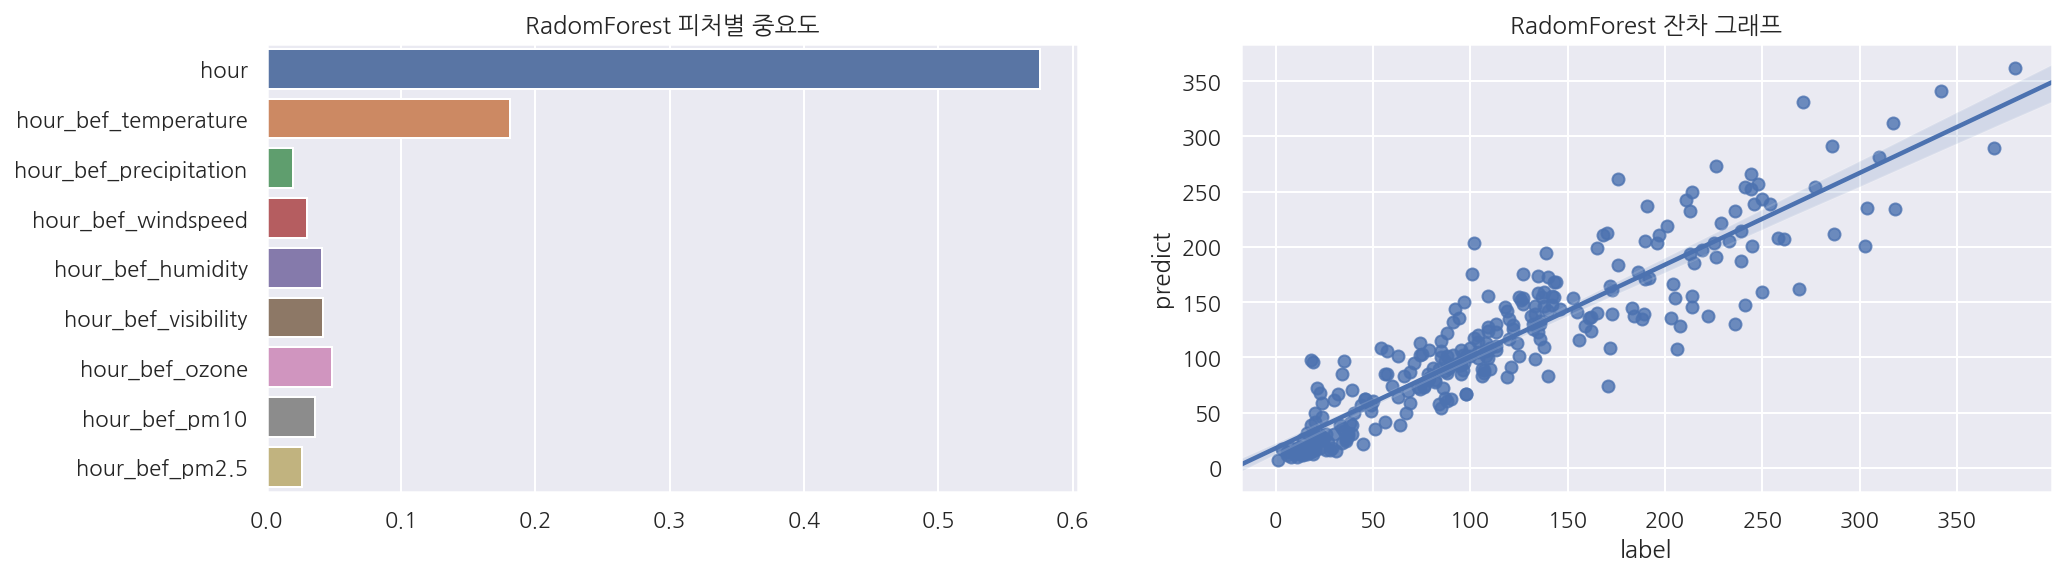

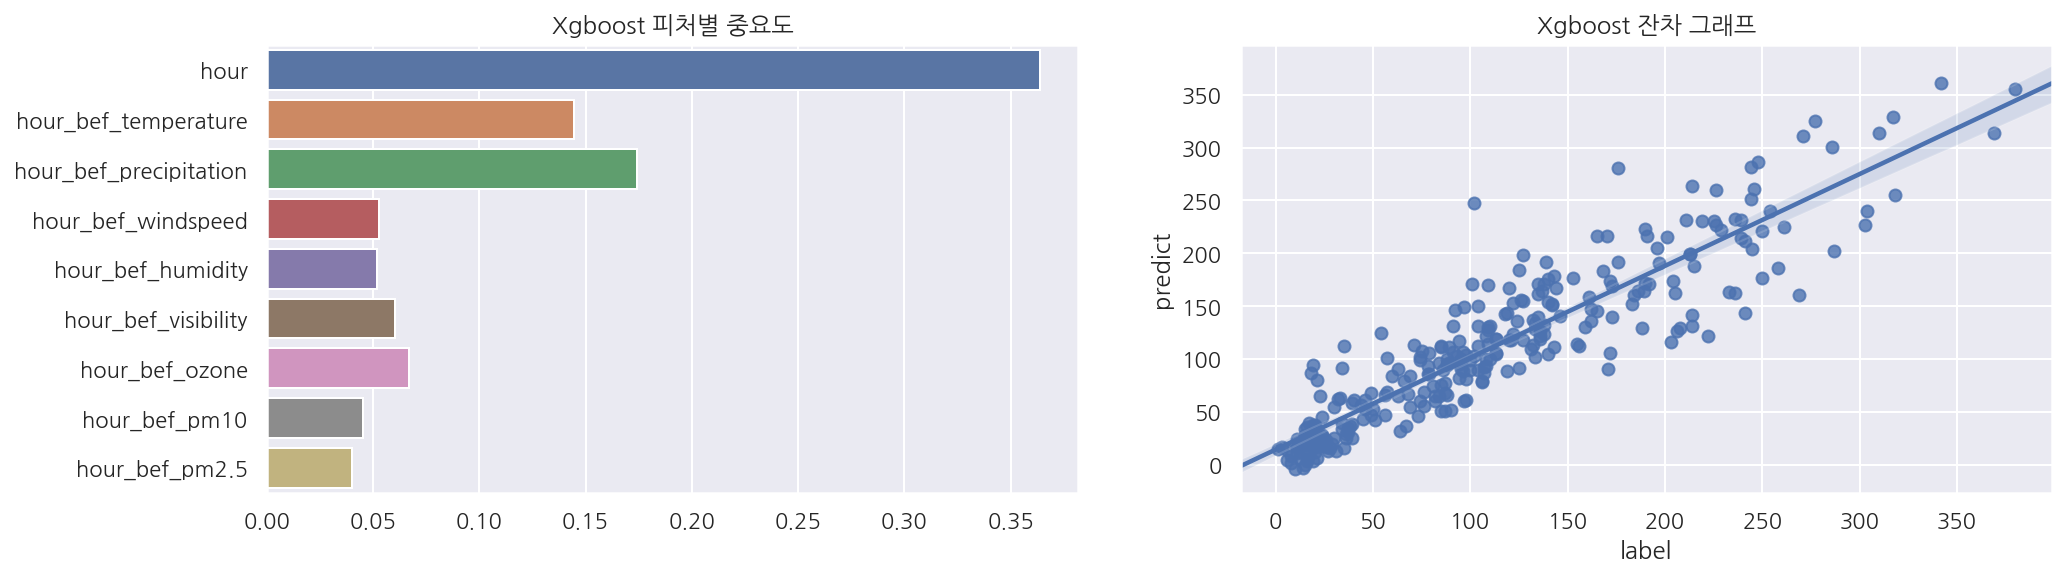

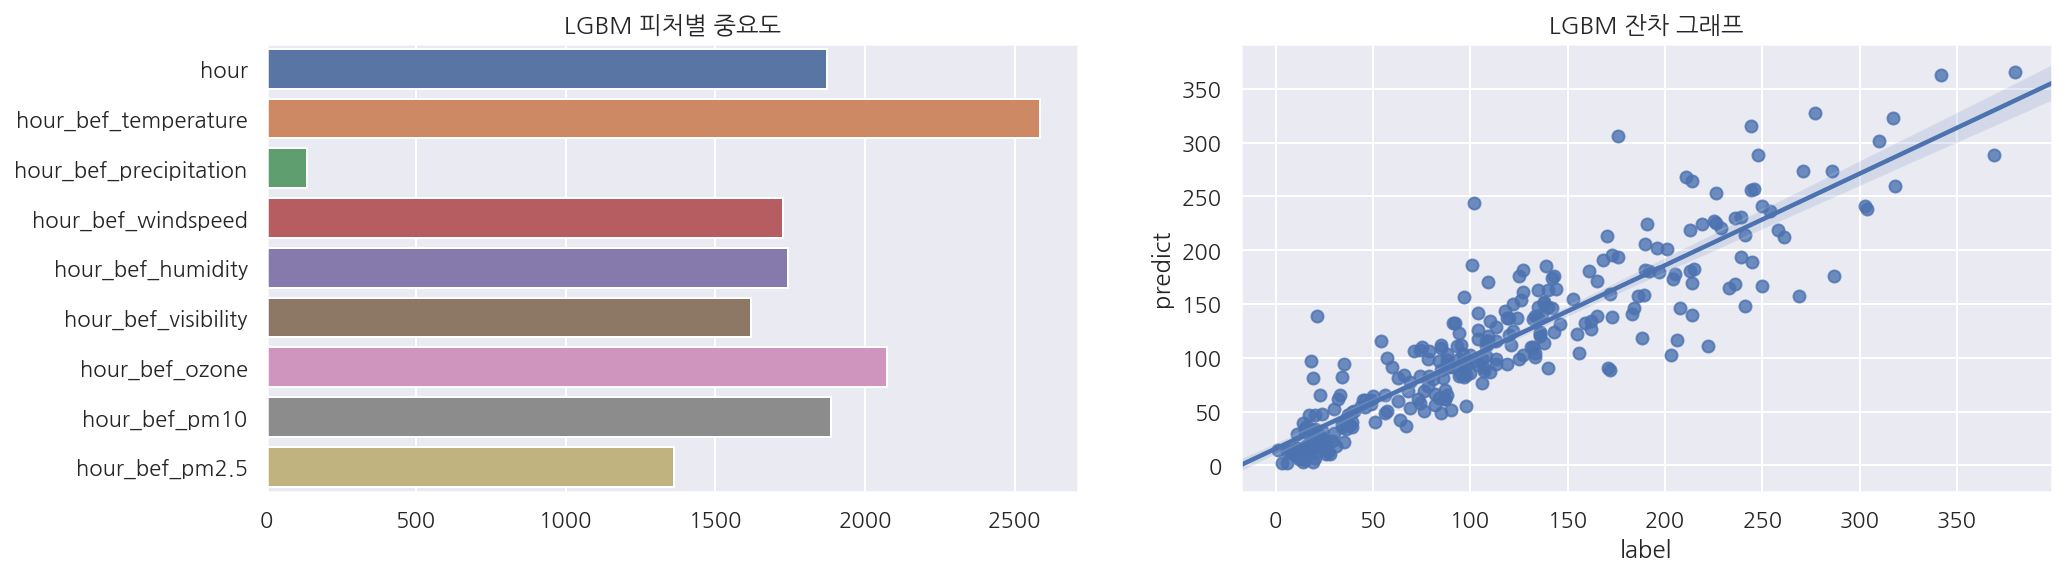

In [23]:
def res_vizualize(data, models, preds ,preprocessing_def):
    
    data_preprocessing_nlr = preprocessing_def
    
    X_train,X_test,y_train,y_test,res_df = data_preprocessing_nlr(data)
    
    for idx,val in enumerate(models):
        names = ['RadomForest','Xgboost','LGBM']
        ## 피처별 중요도
        feature_series = pd.Series(data=models[idx].best_estimator_.feature_importances_, index=X_train.columns) 
        features_series = feature_series.sort_values(ascending=False)
        plt.figure(figsize=(16,14))
        plt.subplot(3,2,1)
        sns.barplot(x=feature_series, y=feature_series.index)
        plt.title(names[idx]+" 피처별 중요도")
        
        ## 잔차 그래프
        residual = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(preds[idx])],axis=1)
        residual.columns = ['label','predict']
        residual.index = y_test.index
        residual['diff']  = np.abs(residual['label'] - residual['predict'])
        plt.subplot(3,2,2)
        plt.title(names[idx]+" 잔차 그래프")
        sns.regplot(x = 'label', y = 'predict', data = residual)    
        
models_1 = [model_rf_v1, model_xgb_v1, model_lgbm_v1]
preds_1 = [model_rf_v1_pred, model_xgb_v1_pred, model_lgbm_v1_pred]

res_vizualize(train, models_1, preds_1, data_preprocessing_nlr_v1)

#### < 이상치 탐지 및 제거 >
    * 시간별 count, temperature에서 이상치 탐지 및 제거
    * [코드 참조](https://hong-yp-ml-records.tistory.com/15)

* 예시로 18시의 대여횟수를 살펴보자. 아래 box-plot을 살펴보면 범위에서 크게 벗어난 값 2개가 보인다. 이러한 이상치는 많은 이유로 발생할 수 있는데 자전거 점검 날이라던지 큰 태풍이 온 날이라던지 자전거 행사가 있다던지 등 다양한 외부,내부 요인이 있을 수 있을것이다.

* 각 시간별 IQR을 벗어나는 count데이터를 이상치로 판단하고 제거해 본다.
    * IQR? => Q3 - Q1: 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이

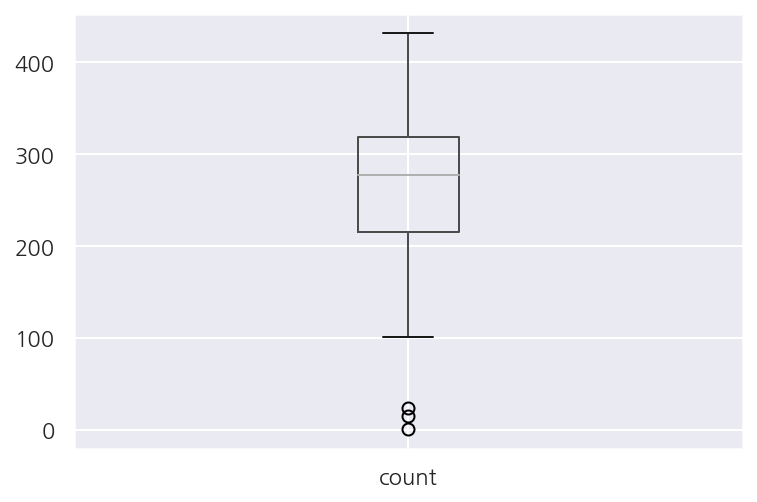

In [24]:
train[train['hour'] == 18][['count']].boxplot()

In [25]:
## 이상치 판별 함수
def detect_outliers(df, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.0 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

outliers_to_drop = detect_outliers(train[train['hour'] == 18][['count']], ["count"])
train[train.index.isin(outliers_to_drop)] # 이상치 row 

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
19,34,18,18.0,1.0,1.9,82.0,685.0,0.044,99.0,42.0,15.0
803,1222,18,27.7,0.0,2.8,35.0,1712.0,0.080,59.0,36.0,425.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1113,1678,18,21.7,0.0,3.4,60.0,1920.0,0.025,37.0,21.0,24.0
1118,1687,18,17.8,0.0,6.5,36.0,1353.0,0.054,122.0,19.0,101.0


In [26]:
## 이상치 제거 함수
def delete_outliers(df):
    
    df = df.copy()
    
    for hour in df['hour'].unique():
        del_list = detect_outliers(df[df['hour'] == hour][['count']], ['count'])
        
        df = df.drop(del_list, axis=0) # .reset_index(drop=True)
    
    return df

In [27]:
## 이상치 제거 함수
def delete_outliers(df):
    
    df = df.copy()
    
    for hour in df['hour'].unique():
        del_list = detect_outliers(df[df['hour'] == hour][['count']], ['count'])
        
        df = df.drop(del_list, axis=0).reset_index(drop=True)
    
    return df


# nlr 전처리 함수에 이상치 제거 함수만 추가
def data_preprocessing_nlr_v2(df): # for not Linear
    df = df.copy()
    
    # outlier 제거
    df = delete_outliers(df)
    
    # 결측값 제거
    df = del_nan(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3,stratify=features['hour'])
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값:36.8986, 최적 parameter:{'max_depth': 21, 'n_estimators': 500}
test rmse :  34.57753502479466
###################################
XGBRegressor 5 CV 시 최적 평균 RMSE 값:36.0558, 최적 parameter:{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'subsample': 0.8}
test rmse :  34.801560795021885
###################################
LGBMRegressor 5 CV 시 최적 평균 RMSE 값:35.7491, 최적 parameter:{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'num_leaves': 12, 'reg_lambda': 10, 'subsample': 0.6}
test rmse :  32.348547099815065
###################################


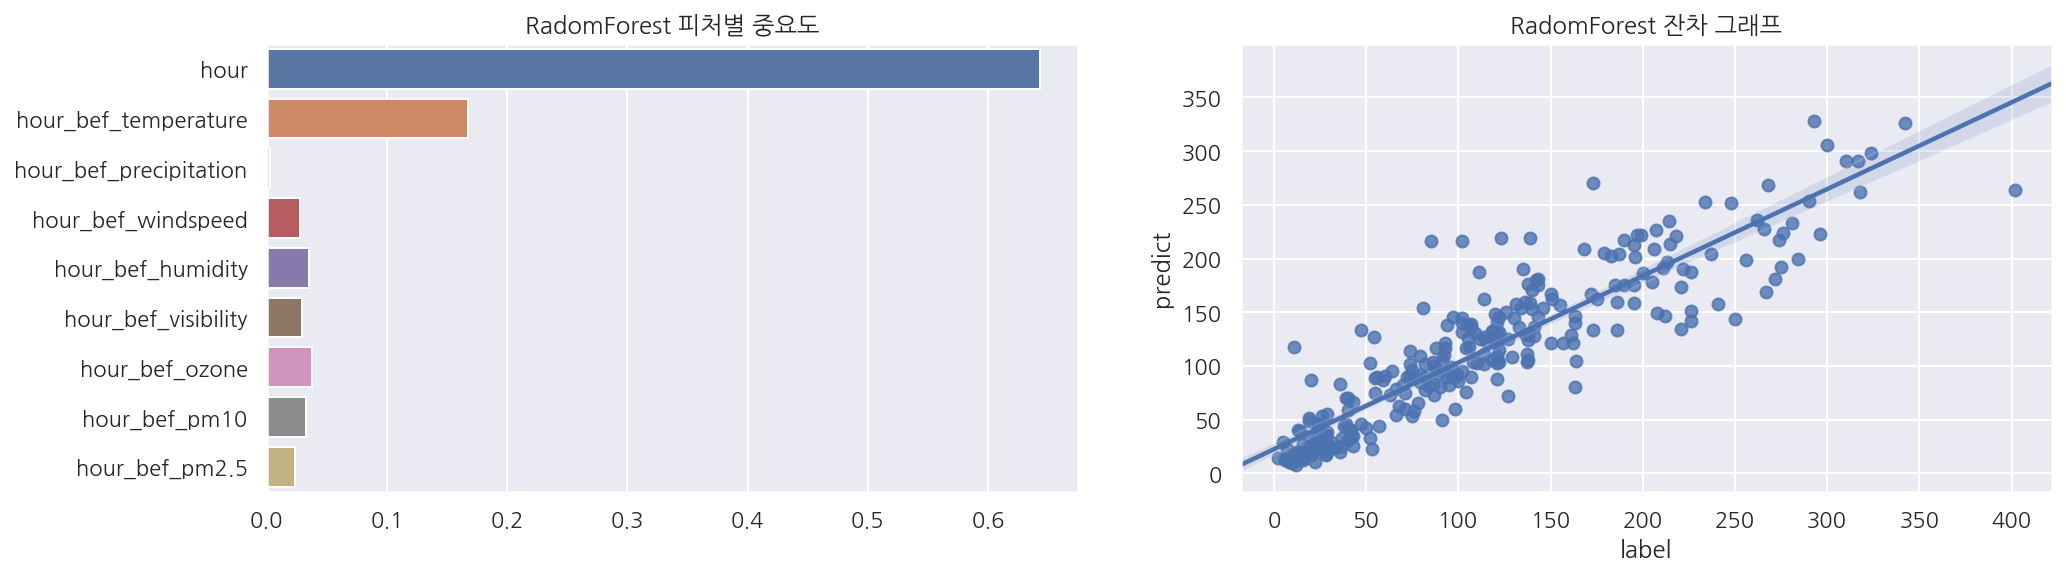

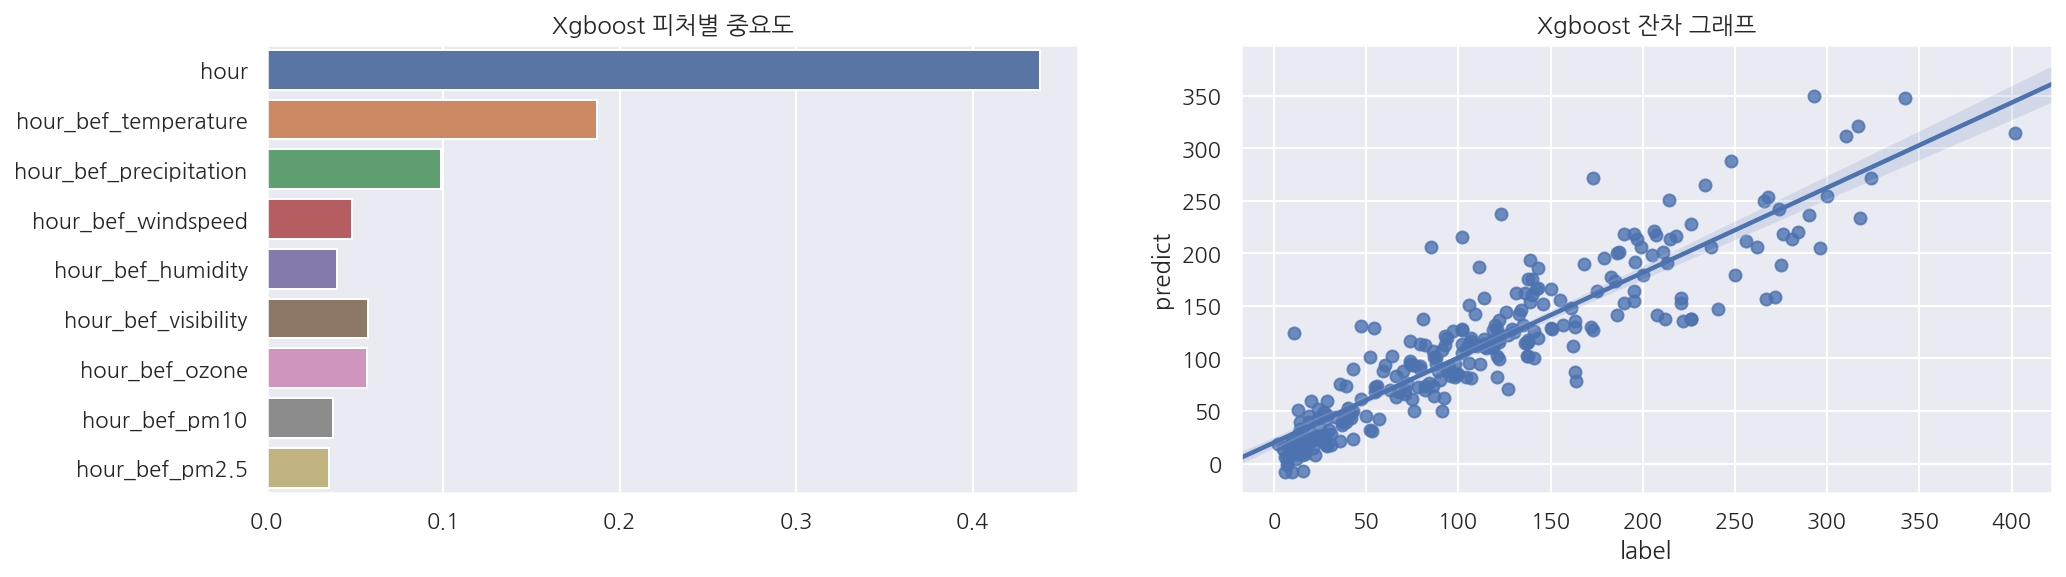

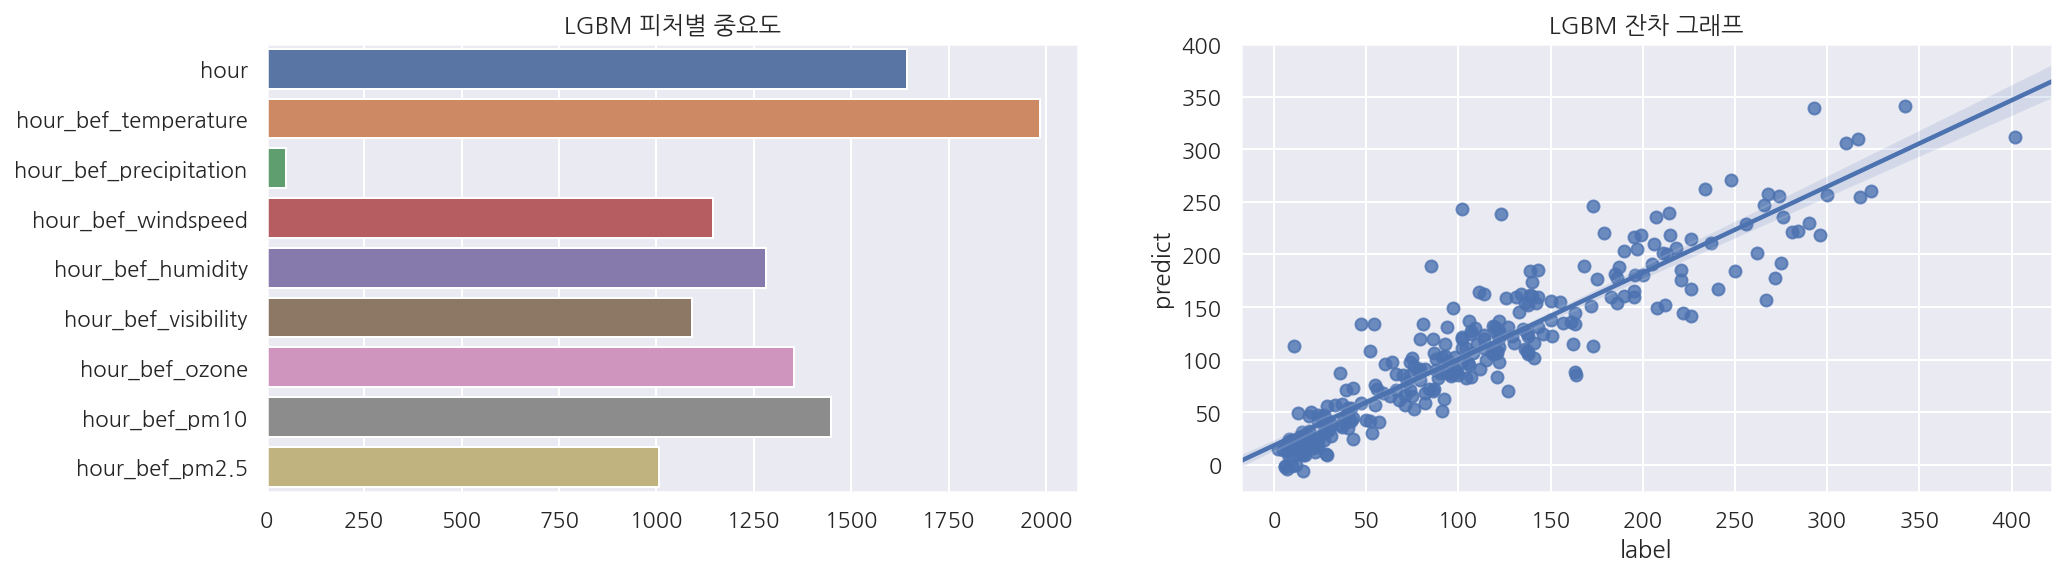

In [28]:
## 이상치 제거 후 RandomForestRegression

RandomForest = RandomForestRegressor(random_state=3)
xgboost = XGBRegressor(n_estimators=1000,silent=True)
lgbm = LGBMRegressor(n_estimators=1000,n_jobs=-1) 

RandomForest_params = {'n_estimators':[500],
                 'max_depth':[8,16,21,32]}

xgboost_params = {'learning_rate':[0.03,0.05,0.1],
                 'colsample_bytree':[0.1,0.5,0.8],
                 'subsample':[0.6,0.8]}

lgbm_params = {'learning_rate':[0.03,0.1],
              'num_leaves':[4,8,12],
              'subsample':[0.6,0.8],
              'colsample_bytree':[0.4,0.6],
              'reg_lambda':[10,1,8]
              }

model_rf_v2,model_rf_v2_pred = find_best_params(train,RandomForest,RandomForest_params, data_preprocessing_nlr_v2)
model_xgb_v2,model_xgb_v2_pred = find_best_params(train,xgboost,xgboost_params, data_preprocessing_nlr_v2)
model_lgbm_v2,model_lgbm_v2_pred = find_best_params(train,lgbm,lgbm_params, data_preprocessing_nlr_v2)

models_2 = [model_rf_v2, model_xgb_v2, model_lgbm_v2]
preds_2 = [model_rf_v2_pred, model_xgb_v2_pred, model_lgbm_v2_pred]

res_vizualize(train, models_2, preds_2, data_preprocessing_nlr_v2)

#### < 결측값 처리에 대한 추가 아이디어 >
    * 기존 결측값 처리 방식은 각 시간별 평균값으로 처리함.
    * 그러나 각 시간별 "기상상황"은 강수여부에 따라 크게 달라짐. (아래의 그래프에서도 확인 가능)
    * 따라서 단순히 각 시간별 평균치가 아닌 시간별 강수여부에 따른 평균치로 대체할것.

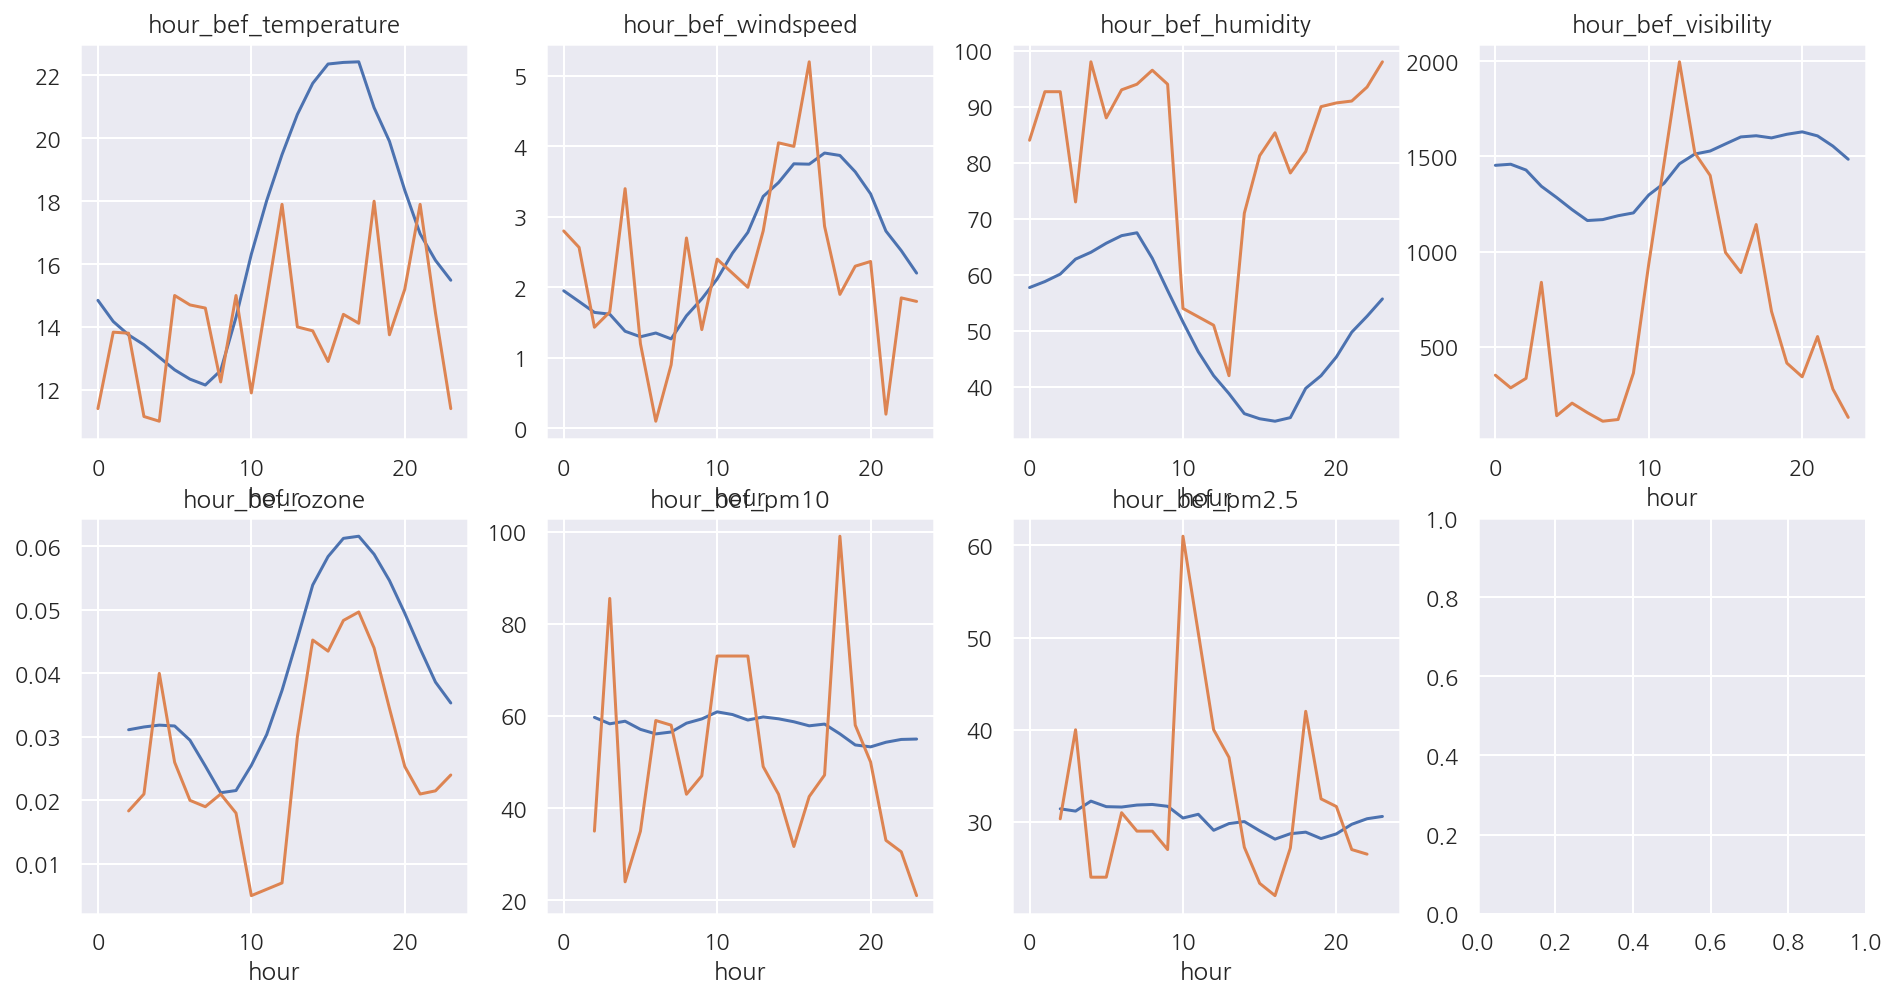

In [29]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
# fig.tight_layout()
weather_features = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity',
               'hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']

for i,feature in enumerate(weather_features):
    row = int(i/4)
    col = i%4
    train[train['hour_bef_precipitation'] == 0].groupby('hour')[feature].mean().plot(ax=axs[row][col],title=feature)
    train[train['hour_bef_precipitation'] == 1].groupby('hour')[feature].mean().plot(ax=axs[row][col])

In [30]:
# 결측치 처리 ver_2
# 시간별 강수여부에 따른 평균치 대체

def del_nan_2(df):
    df = df.copy()
    # hour_bef_precipitation 결측치 제거
    df['hour_bef_precipitation'] = df['hour_bef_precipitation'].fillna(1)
    
    # 각 시간대별 평균값으로 결측치 대체
    
    for col in ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        a = df[df['hour_bef_precipitation'] == 0][col].fillna(df[df['hour_bef_precipitation'] == 0].groupby('hour')[col].transform('mean'))
        b = df[df['hour_bef_precipitation'] == 1][col].fillna(df[df['hour_bef_precipitation'] == 1].groupby('hour')[col].transform('mean'))
        
        tmp_index = df[col].index
        
        c = pd.concat([a,b])
        c = c.reindex(tmp_index)
        df[col] = c
        
    
    # 1차 결측치 삭제 후, ozone, pm10, pm2.5의 hour_1에 해당하는 결측치만 남음.
   # ozone, pm10, pm2.5 결측값을 hour_0, hour_2의 평균값으로 대체
    for col in ['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']:
        hour_0 = df[df['hour'] == 0][col].mean()
        hour_2 = df[df['hour'] == 2][col].mean()
        res = np.mean([hour_0,hour_2])
        df[col] = df[col].fillna(res)
        
    return df

* 결측치 제거 version_2를 적용하여 평가 및 최적 파라미터를 도출해 낸다.

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값:36.8882, 최적 parameter:{'max_depth': 32, 'n_estimators': 500}
test rmse :  34.64857968864043
###################################
XGBRegressor 5 CV 시 최적 평균 RMSE 값:35.9568, 최적 parameter:{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'subsample': 0.8}
test rmse :  34.53657894154108
###################################
LGBMRegressor 5 CV 시 최적 평균 RMSE 값:35.6951, 최적 parameter:{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'num_leaves': 12, 'reg_lambda': 10, 'subsample': 0.6}
test rmse :  32.98741653411534
###################################


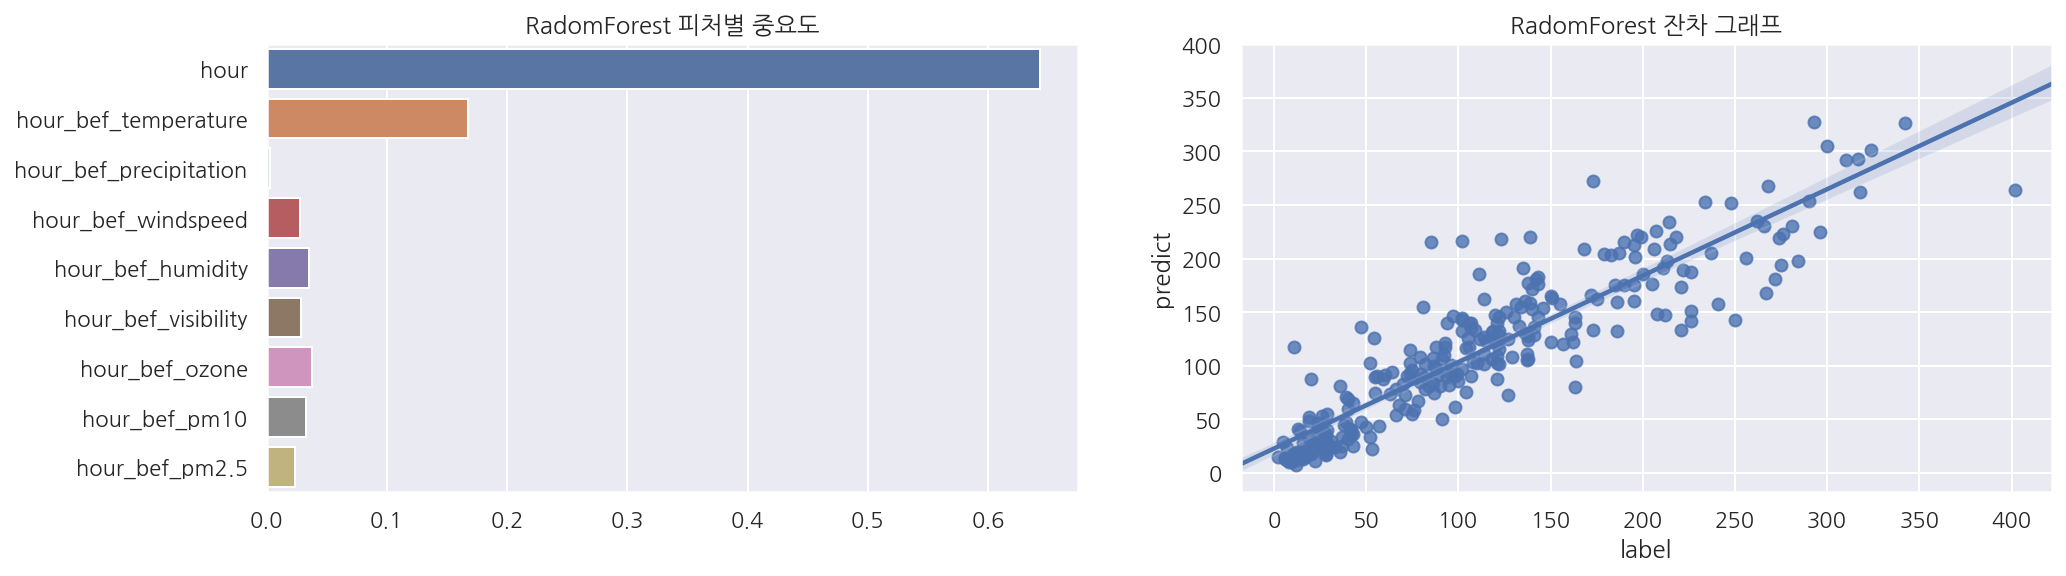

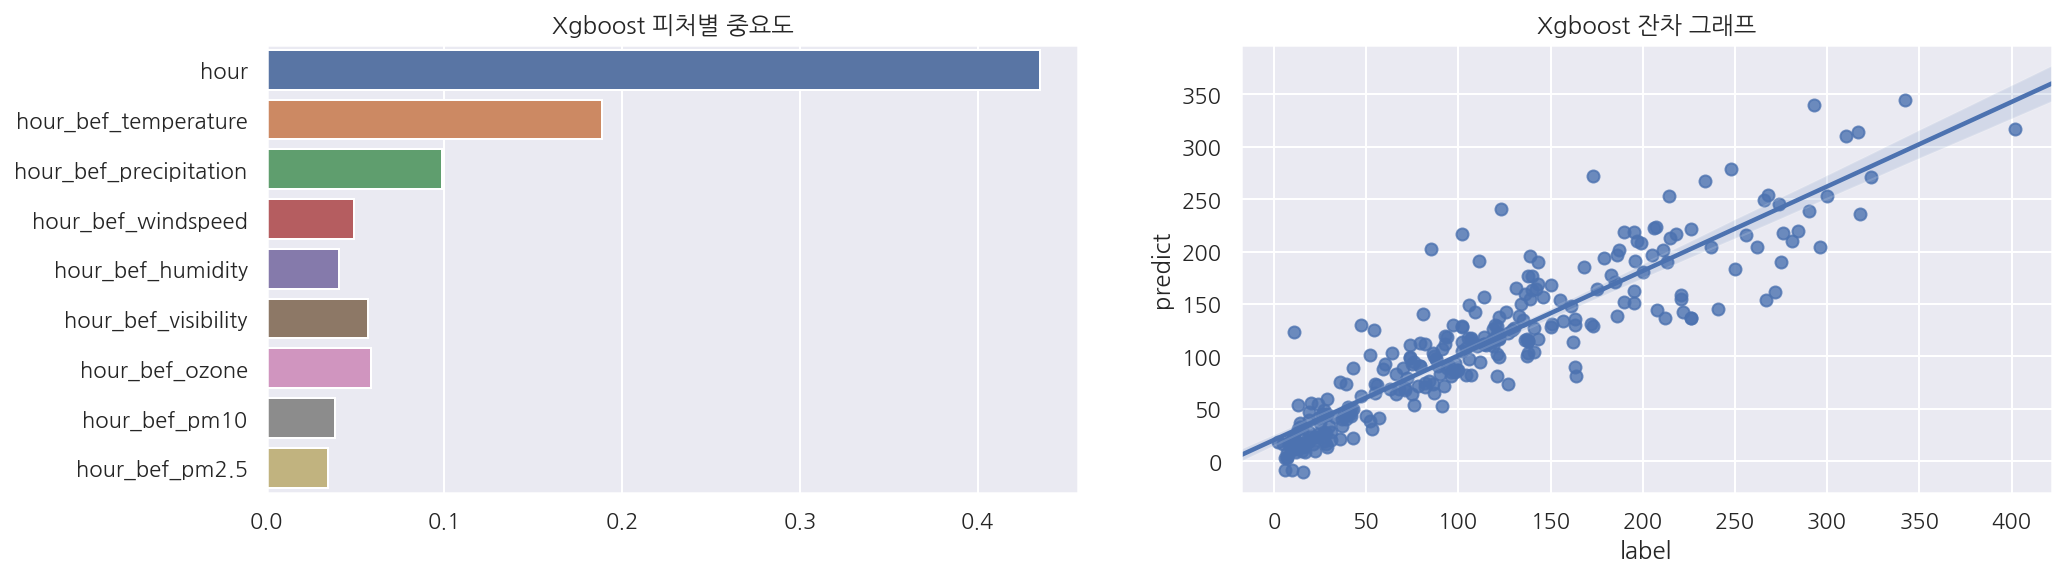

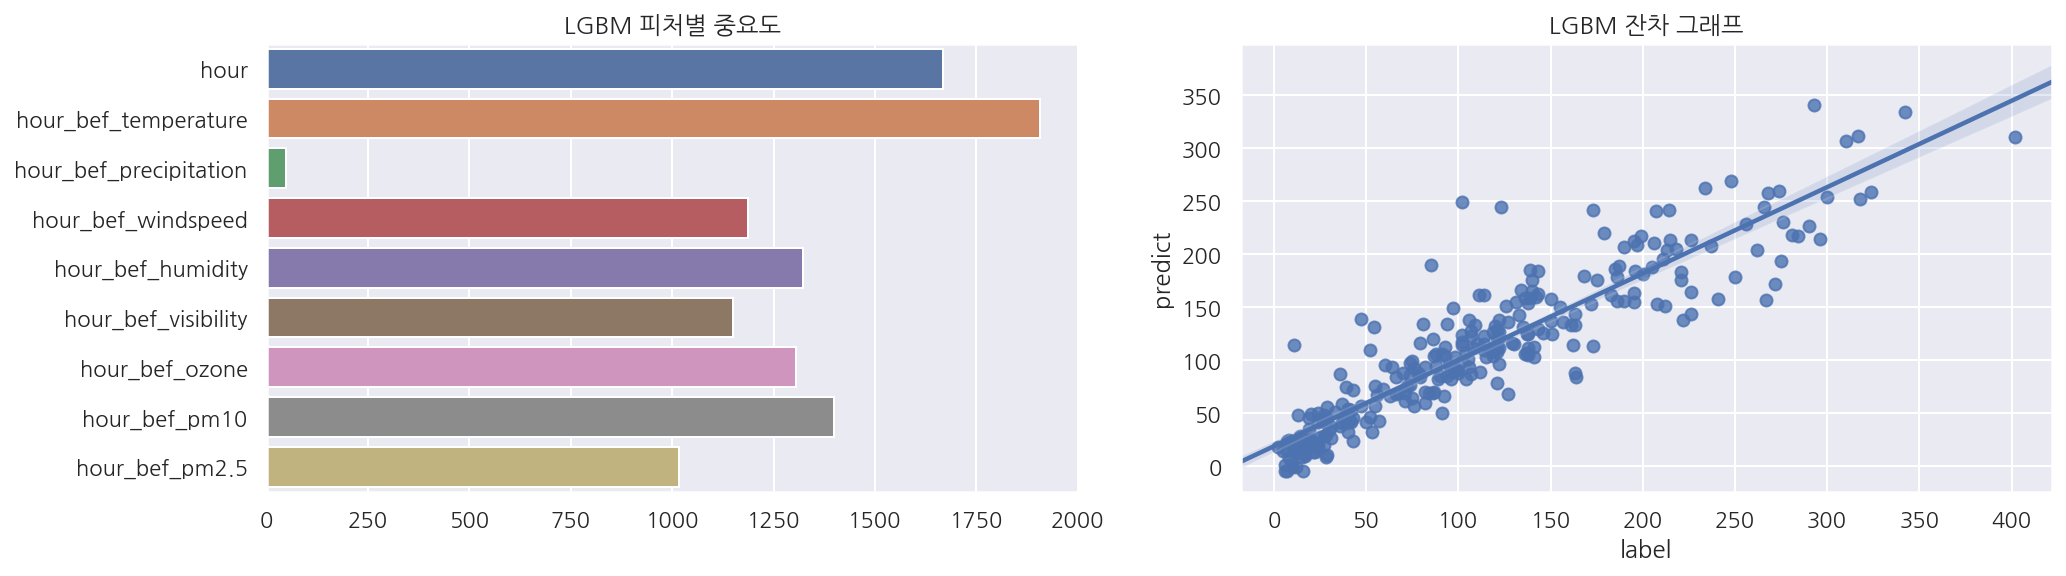

In [31]:
# nlr 전처리 함수에 이상치 제거, 결측치 제거(ver2) 추가
def data_preprocessing_nlr_v3(df): # for not Linear
    df = df.copy()
    
    # outlier 제거
    df = delete_outliers(df)
    
    # 결측값 제거
    df = del_nan_2(df)
    
    features = df.loc[:,:"hour_bef_pm2.5"]  # 피처 선택
    target = df['count'] # target
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # train test split
    X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=3,stratify=features['hour'])
    
    # return train test & res_df
    return X_train,X_test,y_train,y_test,features

RandomForest = RandomForestRegressor(random_state=3)
xgboost = XGBRegressor(n_estimators=1000,silent=True)
lgbm = LGBMRegressor(n_estimators=1000,n_jobs=-1) 

RandomForest_params = {'n_estimators':[300,500],
                 'max_depth':[8,16,21,32]}

xgboost_params = {'learning_rate':[0.03,0.05,0.1],
                 'colsample_bytree':[0.1,0.5,0.8],
                 'subsample':[0.6,0.8]}

lgbm_params = {'learning_rate':[0.03,0.1],
              'num_leaves':[4,8,12],
              'subsample':[0.6,0.8],
              'colsample_bytree':[0.4,0.6],
              'reg_lambda':[10,1,8]
              }

model_rf_v3,model_rf_v3_pred = find_best_params(train, RandomForest, RandomForest_params, data_preprocessing_nlr_v3)
model_xgb_v3,model_xgb_v3_pred = find_best_params(train, xgboost, xgboost_params, data_preprocessing_nlr_v3)
model_lgbm_v3,model_lgbm_v3_pred = find_best_params(train, lgbm, lgbm_params, data_preprocessing_nlr_v3)

models_3 = [model_rf_v3, model_xgb_v3, model_lgbm_v3]
preds_3 = [model_rf_v3_pred, model_xgb_v3_pred, model_lgbm_v3_pred]

res_vizualize(train, models_3, preds_3, data_preprocessing_nlr_v3)

#### < 스태킹 앙상블 모델을 통한 회귀 예측 >

#### < 최종 모델링 > 
    * 전체 전처리 과정을 모듈화
        * 선형 / 회귀 트리
    * 최적 모델로 전체 학습데이터 train 후 test 데이터에 대해 예측
        * 실제 제출 점수 확인

In [ ]:
## Full processing
## linear model

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

################################################

## train 전체 학습 
## 제출할 test로 예측
def res_data_preprocessing_lr(data):
    
    data = data.copy()
    
    # 결측값 제거
    data = del_nan(data)
    
    ## standard Scaler & Onehot encoder
    sc = StandardScaler()
    
    features = data.loc[:,:] # 피처 선택
    features = features.drop(['id'],axis=1) # id 컬럼 삭제
    
    # one hot column list
    columns_to_encode = ['hour','hour_bef_precipitation']
    # scaling column list
    columns_to_scale = ['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility','hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']
    
    res_preprocessed_features = pd.get_dummies(features,columns=columns_to_encode) # one hot encoding
    scaled_columns = sc.fit_transform(features[columns_to_scale]) # standard Scaling   
    res_preprocessed_features[columns_to_scale] = scaled_columns # one hot 결과와 scaling 결과 합침
    
    # return res_df
    return res_preprocessed_features
    
# get final preprocessed train/test    
res_train = res_data_preprocessing_lr(train)
res_target = res_train['count']
res_train = res_train.drop(['count'],axis=1)

res_test = res_data_preprocessing_lr(test)

In [ ]:
# res _ model _ 1
# Simple LinearRegression
model_res_1 = LinearRegression()
model_res_1.fit(res_train,res_target)
res_1_predict = model_res_1.predict(res_test)

## submit
submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_1_predict

# submission.to_csv('res_model_1.csv',index=False)

In [36]:
## Full processing
## not linear model

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

################################################

## train 전체 학습 
## 제출할 test로 예측
def res_data_preprocessing_nlr(data):
    
    data = data.copy()

    # outlier 제거
#     try:
#         data = delete_outliers(data) 
#     except:
#         pass
    
    # 결측값 제거
    data = del_nan(data)
#     data = del_nan_2(data)
    
    features = data.loc[:,:]  # 피처 선택
    features = features.drop(['id'],axis=1) # id 컬럼 삭제    
    
    # return res_df
    return features

    
# get final preprocessed train/test
res_train = res_data_preprocessing_nlr(train)
res_target = res_train['count']
res_train = res_train.drop(['count'],axis=1)

res_test = res_data_preprocessing_nlr(test)

In [37]:
# res _ model _ 3
# RandomForest Regression
# 결측치 대체 ver_1
model_rf_res_3 = RandomForestRegressor(n_estimators=500, max_depth=32)
model_rf_res_3.fit(res_train,res_target)
rf_res_3_predict = model_rf_res_3.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = rf_res_3_predict

submission.to_csv('res_model_rf_3.csv',index=False)

###########################################

model_xgb_res_3 = XGBRegressor(n_estimators=500, colsample_bytree=0.8, learning_rate=0.05, subsample=0.6)
model_xgb_res_3.fit(res_train,res_target)
xgb_res_3_predict = model_xgb_res_3.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = xgb_res_3_predict

submission.to_csv('res_model_xgb_3.csv',index=False)

###########################################


model_lgbm_res_3 = LGBMRegressor(n_estimators=500, colsample_bytree=0.6, learning_rate=0.03, num_leaves=16, reg_lambda=10, subsample=0.6)
model_lgbm_res_3.fit(res_train,res_target)
xgb_lgbm_3_predict = model_lgbm_res_3.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = xgb_lgbm_3_predict

submission.to_csv('res_model_lgbm_3.csv',index=False)

[21:30:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
# res _ model _ 4
# RandomForest Regression
# 이상치 제거
# 결측치 대체 ver_2
model_res_4 = RandomForestRegressor(n_estimators=500, max_depth=21)
model_res_4.fit(res_train,res_target)
res_4_predict = model_res_4.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_4_predict
submission.to_csv('res_model_4.csv',index=False)

################################# 

model_res_5 = XGBRegressor(n_estimators=1000, colsample_bytree=0.8, learning_rate=0.03, subsample=0.8,silent=True)
model_res_5.fit(res_train,res_target)
res_5_predict = model_res_5.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_5_predict
submission.to_csv('res_model_5.csv',index=False)

################################# 

model_res_6 = LGBMRegressor(n_estimators=1000, colsample_bytree=0.6, learning_rate=0.03,
                              num_leaves=12, reg_lambda=10, subsample=0.6)
model_res_6.fit(res_train,res_target)
res_6_predict = model_res_6.predict(res_test)

submission = pd.read_csv("./data/submission.csv")
submission['count'] = res_6_predict
submission.to_csv('res_model_6.csv',index=False)